### Data Loading

In [3]:
import pandas as pd
from helpers import *

Firstly, let's create our data-frame from our source data. Additionally, we'll transform the `Score_home` and `Score_away` columns into our target variable such that:
$$
y = \cases{-1 \\ 
            0 \\
            1 }
$$
using the helper function `score_to_win()`

In [4]:
DATA_SRC = '../Data/PL_site_2006_2018/masterdata.csv'
df = pd.read_csv(DATA_SRC)

# create win/lose label
df['target'] = df[['Score_home', 'Score_away']].apply(score_to_win, axis = 1)
df.head()

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,...,Corners_away,Offsides_home,Offsides_away,Yellow_cards_home,Yellow_cards_away,Fouls_conceded_home,Fouls_conceded_away,Red_cards_home,Red_cards_away,target
0,5937,Blackburn,Reading,3,3,54.0,46.0,6.0,4.0,15.0,...,10.0,5.0,3.0,2.0,0.0,18.0,7.0,0.0,0.0,0
1,5938,Bolton,Aston Villa,2,2,47.1,52.9,2.0,2.0,11.0,...,6.0,0.0,2.0,2.0,1.0,10.0,11.0,0.0,0.0,0
2,5939,Chelsea,Everton,1,1,59.3,40.7,7.0,6.0,20.0,...,2.0,6.0,2.0,2.0,1.0,13.0,7.0,0.0,0.0,0
3,5940,Liverpool,Charlton,2,2,61.6,38.4,5.0,4.0,23.0,...,2.0,6.0,4.0,0.0,0.0,5.0,13.0,0.0,0.0,0
4,5941,Man Utd,West Ham,0,1,65.3,34.7,7.0,2.0,30.0,...,3.0,0.0,1.0,0.0,2.0,13.0,12.0,0.0,0.0,-1


### Feature Extraction
Now, we must drop several variables from the above table in order to fit our model. We'll create `df_wo` to pass in. This leaves us with 24 avaiable features.

In [5]:
df_wo = df.drop(columns = ['target', 'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away'])
list(df_wo)

['Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away']

## EDA
### Correlation

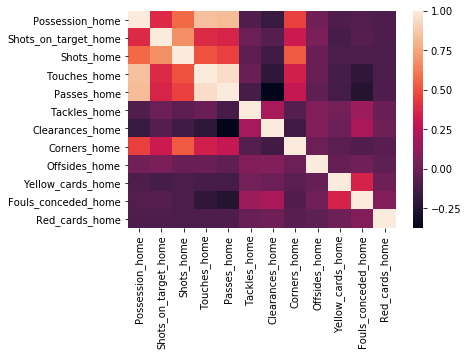

In [7]:
import seaborn as sns
home_features = [ f for f in list(df_wo) if '_home' in f ]
corr = df_wo[home_features].corr()
_ = sns.heatmap(corr)

### Variance Inflation
It is likely the case that several of the above variables are collinear. Now, in many models this might not have an effect as the coefficients for one variable will be high while the other will just be nullified. However, based on our correlation analysis it is clear some variables are capturing the same information. For example, possession is highly correlated with touches and passes. This isn't surprising, if a team possesses the ball for long stretches they are likely moving the ball around. 

So, we'll use the concept of << Math >>

We can use `statsmodels.stats.outliers_influence.variance_inflation_factor` to perform this analysis in Python.

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vifs = []
for i, feature in enumerate(list(df_wo)):
    vif_tup = (feature, variance_inflation_factor(df_wo.values, i))
    vifs.append( vif_tup )
print(vifs)

[('Possession_home', 421.664198311881), ('Possession_away', 419.81062314039434), ('Shots_on_target_home', 8.782441665663617), ('Shots_on_target_away', 7.396037301381689), ('Shots_home', 22.209855032690577), ('Shots_away', 18.651114834578262), ('Touches_home', 1672.9450410979687), ('Touches_away', 1627.9214695521432), ('Passes_home', 853.6608606060394), ('Passes_away', 820.9624289229962), ('Tackles_home', 14.462257682807621), ('Tackles_away', 14.809579847791026), ('Clearances_home', 12.388657234887198), ('Clearances_away', 14.60806502888385), ('Corners_home', 7.860642317099764), ('Corners_away', 6.471201785370187), ('Offsides_home', 2.7626312752498734), ('Offsides_away', 2.595120818834656), ('Yellow_cards_home', 2.990258155080378), ('Yellow_cards_away', 3.5407903131487735), ('Fouls_conceded_home', 14.534481363962977), ('Fouls_conceded_away', 14.864641611614935), ('Red_cards_home', 1.1122869843284866), ('Red_cards_away', 1.1380676710924316)]


## Feature Engineering
### Form
Often, in the sport, commentators and analysts point to a team's form (essentially the recent performance) as being somewhat important in their performance in an individual game. The thinking goes: if this team has played well, they will continue to play well. It is not dissimilar to the concept of momentum, in a way. 
<< Math >>

In [9]:
scores = df[['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away']].values
gd = gd_vectors(scores)

away_form_linear = []
home_form_linear = []
away_form_exp = []
home_form_exp = []
for game in scores:
    id, home_team, away_team, _, _ = game
    away_form_exp.append( exponential_momentum(id, away_team, gd, alpha = .65) )
    home_form_exp.append( exponential_momentum(id, home_team, gd, alpha = .65) )
    away_form_linear.append( linear_momentum(id, away_team, gd) )
    home_form_linear.append( linear_momentum(id, home_team, gd) )


df_form = df_wo.copy()
df_form['away_form_linear'] = pd.Series(away_form_linear)
df_form['home_form_linear'] = pd.Series(home_form_linear)
df_form['away_form_exp'] = pd.Series(away_form_exp)
df_form['home_form_exp'] = pd.Series(home_form_exp)
list(df_form)

['Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away',
 'away_form_linear',
 'home_form_linear',
 'away_form_exp',
 'home_form_exp']

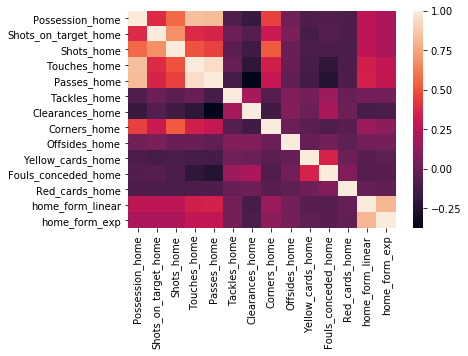

In [10]:
home_features = [ f for f in list(df_form) if 'home' in f ]
corr = df_form[home_features].corr()
_ = sns.heatmap(corr)

### Transfer Spending / Market Value

## Modeling

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [12]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier()]

In [13]:
X = df_wo.values
df_form.drop(columns = ['home_form_linear', 'away_form_linear'], inplace = True)
X_form = df_form.values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
X_train_form, X_test_form, y_train_form, y_test_form = train_test_split(X_form, y, test_size = .2)

In [14]:
for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6304824561403509 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.581140350877193 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.631578947368421 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.44298245614035087 



In [15]:
for clf in clfs:
    clf.fit(X_train_form, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_form, y_test_form), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6425438596491229 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5592105263157895 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.631578947368421 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.44846491228070173 



### Coefficient Investigation

In [ ]:
# change to clfs[i]
for i, feature in enumerate(list(df_wo)):
    print(feature, ": ", lr.coef_[:,i])

### Variance Inflation